In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from safetensors import safe_open 
from scipy import stats
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 15})

/mnt/c/Users/yota/Documents/BCCN/lab_rotations/Muller_lab/modified_PURE/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # for UMAP plot
# import os
# import torchvision
# import umap
# import yaml
# from crp.attribution import CondAttribution
# from crp.concepts import ChannelConcept
# from crp.helper import load_maximization

# from crp.visualization import FeatureVisualization
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from safetensors import safe_open
# from scipy import stats
# from sklearn.cluster import KMeans
# from torchvision.utils import make_grid
# from zennit.composites import EpsilonPlusFlat

# import sys
# sys.path.append('../../../')
# from datasets import get_dataset
# from models import get_canonizer, get_fn_model_loader
# from utils.helper import get_layer_names_model
# from utils.render import vis_opaque_img_border

# import zennit.image as zimage

In [3]:
import matplotlib
import pandas as pd
matplotlib.__version__
np.__version__
pd.__version__

'2.0.3'

In [5]:
random_seed=0
dataset_name = "imagenette2" #"imagenet"
model_name = "resnet34_timm" # "resnet101_timm"
SPLIT = "test"
layer_name = "block_3" # you investigate mixed-selectivity of neurons in this layer.
list_attribution_layer_name = ["previous", "block_1", "block_0"] # you compute relevance scores in this layer. 
skip_distance_evaluation = True # if True, you skip the evaluation of CLIP distances. Note you need the results from scripts/run_evaluation_choose_attribution_layer.sh.
# config_file = "../../../configs/imagenette2/resnet34_timm.yaml"
# with open(config_file, "r") as stream:
#     try:
#         config = yaml.safe_load(stream)
#         config["config_name"] = os.path.basename(config_file)[:-5]
#     except yaml.YAMLError as exc:
#         print(exc)
#         config = {}

In [6]:
# Collect data to plot 
for i_attribution_layer, attribution_layer_name in enumerate(list_attribution_layer_name): 
    print(attribution_layer_name)
    # if you check relevance in the immediate previous layer, you need to get the name.
    if attribution_layer_name == 'previous': 

        # Add the paths to the custom modules    
        import sys
        import os
        # Print the current working directory
        #print("Current working directory:", os.getcwd())
        sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
        from models import get_fn_model_loader
        from utils.helper import get_layer_names_model
        model = get_fn_model_loader(model_name)(ckpt_path=None, n_class=None)
        layer_names = get_layer_names_model(model, model_name)
        attribution_layer_name = layer_names[layer_names.index(layer_name) - 1]
        print(layer_names)
        print(f'previous = {attribution_layer_name}')

    # clip and dino data are the same across different attribution layers.
    if i_attribution_layer == 0: 
       
        tensors = {}
        path = f"../../../results/global_features/{dataset_name}/{model_name}"
        with safe_open(f"{path}/latent_embeddings_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)

        M = 50    # number of reference samples
        CLIP_embeddings = tensors["CLIP"][:, :M]
        DINO_embeddings = tensors["DINO"][:, :M]

    # load the relevance scores and activations 
    tensors = {}
    path = f"../../../results/global_features/{dataset_name}/{model_name}"
    with safe_open(f"{path}/latent_features_{layer_name}_{SPLIT}_{attribution_layer_name}.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    PURE_embeddings = tensors["cond_rel"][:, :M]
        
    if i_attribution_layer == 0: 
        # activations are the same across different attribution layers.
        #ACT_embeddings = tensors["mean_act"][:, :M]
        # store the data to plot
        X = [DINO_embeddings, PURE_embeddings] #, ACT_embeddings]
        X_0 = CLIP_embeddings
        label_list = ["DINOv2", attribution_layer_name] #, "activations"]
        
        print(f'CLIP shape: {X_0.shape}')
        print(f'DINO shape: {DINO_embeddings.shape}')
        print(f'PURE shape: {PURE_embeddings.shape}')
        #print(f'ACT shape: {ACT_embeddings.shape}')

    else:
        X.append(PURE_embeddings)
        label_list.append(attribution_layer_name)
        print(f'PURE shape: {PURE_embeddings.shape}')

previous
['block_0', 'block_1', 'block_2', 'block_3']
previous = block_2
CLIP shape: torch.Size([512, 50, 768])
DINO shape: torch.Size([512, 50, 768])
PURE shape: torch.Size([512, 50, 256])
block_1
PURE shape: torch.Size([512, 50, 128])
block_0
PURE shape: torch.Size([512, 50, 64])


## Evaluation

### correlation in distance matrices between CLIP space and another (e.g. original PURE, activation, etc)

In [7]:
# Function to compute pairwise distances for a given array
def compute_pairwise_distances(array):
    # Expand dimensions to compute pairwise differences
    array_expanded = np.expand_dims(array, axis=1)
    pairwise_diff = array_expanded - array_expanded.transpose(1, 0, 2)
    pairwise_distances = np.linalg.norm(pairwise_diff, axis=2)
    return pairwise_distances

num_neurons =  X_0.shape[0] # number of neurons
num_images = X_0.shape[1] # number of images
corr_data = np.zeros((num_neurons, len(X)))

clip_distance_all_neurons = np.zeros((num_neurons, num_images, num_images))
other_distances_all_neurons = np.zeros((num_neurons, len(X), num_images, num_images))
for i_neuron in range(num_neurons):
    # CLIP distance for neuron i_neuron 
    clip_distance = compute_pairwise_distances(X_0[i_neuron].detach())
    clip_distance_all_neurons[i_neuron, :, :] = clip_distance
    # extract the lower triangle of the distance matrix 
    flatten_clip_distance = clip_distance[np.tril_indices(clip_distance.shape[0], k=-1)]

    # PURE distance, activation distance, etc for neuron_i_neuron
    for i_space, x in enumerate(X):
        distance_matrix = compute_pairwise_distances(x[i_neuron].detach())
        other_distances_all_neurons[i_neuron, i_space, :, :] = distance_matrix 
        # extract the lower triangle of the distance matrix 
        flatten_distance = distance_matrix[np.tril_indices(distance_matrix.shape[0], k=-1)]
        corr_data[i_neuron, i_space] = np.corrcoef(flatten_clip_distance, flatten_distance)[0, 1]


print(f'len corr_data: {corr_data.shape}')
scatter_label_list = []
for i_label, label in enumerate(label_list):
    if label == "DINOv2" or label == "activations": # skip DINOv2
        continue
    scatter_label_list.append(label)


len corr_data: (512, 4)


### Exampler neurons

In [8]:
num_neurons_to_plot_each_list = 1
#improvement_amount = 0.1

block_2_loc = label_list.index("block_2")
block_1_loc = label_list.index("block_1")
block_0_loc = label_list.index("block_0")

block_2_most_separated_neurons_list = np.argsort(-corr_data[:, block_2_loc])[:num_neurons_to_plot_each_list] # top two neurons that are most separated from CLIP distances
block_1_most_separated_neurons_list = np.argsort(-corr_data[:, block_1_loc])[:num_neurons_to_plot_each_list] # top two neurons that are most separated from CLIP distances
block_0_most_separated_neurons_list = np.argsort(-corr_data[:, block_0_loc])[:num_neurons_to_plot_each_list] # top two neurons that are most separated from CLIP distances
#block_1_improved_neurons_list = np.where((corr_data[:, block_2_loc] + improvement_amount) < corr_data[:, block_1_loc])[0] # neurons that show better alignment with CLIP distances in block_1 than block_2
#block_0_improved_neurons_list = np.where((corr_data[:, block_2_loc] + improvement_amount) < corr_data[:, block_0_loc])[0] # neurons that show better alignment with CLIP distances in block_0 than block_2
block_1_improved_neurons_list = [np.argmax(corr_data[:, block_1_loc] - corr_data[:, block_2_loc])] # neurons that show better alignment with CLIP distances in block_1 than block_2
block_0_improved_neurons_list = [np.argmax(corr_data[:, block_0_loc] - corr_data[:, block_2_loc])] # neurons that show better alignment with CLIP distances in block_0 than block_2

print(f"block_2_most_separated_neurons_list: {block_2_most_separated_neurons_list}")
print(f"block_1_most_separated_neurons_list: {block_1_most_separated_neurons_list}")
print(f"block_0_most_separated_neurons_list: {block_0_most_separated_neurons_list}")
print(f"block_1_improved_neurons_list: {block_1_improved_neurons_list}")
print(f"block_0_improved_neurons_list: {block_0_improved_neurons_list}")

num_block_1_improved_neurons = len(block_1_improved_neurons_list)
num_block_0_improved_neurons = len(block_0_improved_neurons_list)

neurons_list = \
    list(block_2_most_separated_neurons_list) + \
    list(block_1_most_separated_neurons_list) + \
    list(block_0_most_separated_neurons_list) + \
    list(block_1_improved_neurons_list) + \
    list(block_0_improved_neurons_list)

neurons_list = \
    list(block_2_most_separated_neurons_list) + \
    list(block_1_improved_neurons_list) + \
    list(block_0_improved_neurons_list)

print(neurons_list)

block_2_most_separated_neurons_list: [4]
block_1_most_separated_neurons_list: [327]
block_0_most_separated_neurons_list: [101]
block_1_improved_neurons_list: [94]
block_0_improved_neurons_list: [100]
[4, 94, 100]


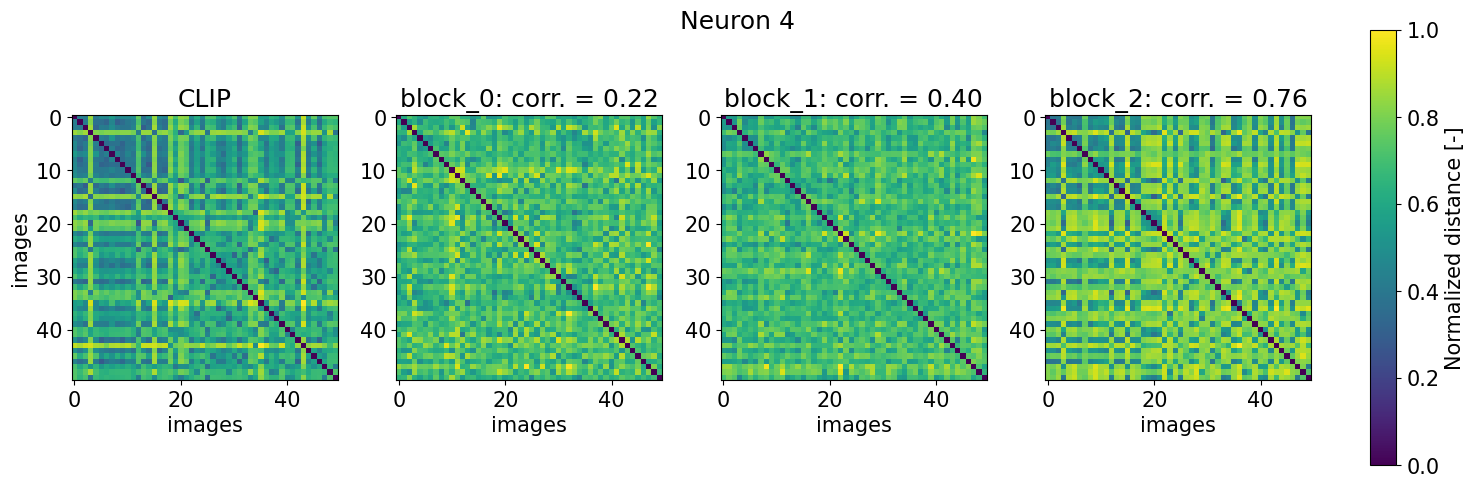

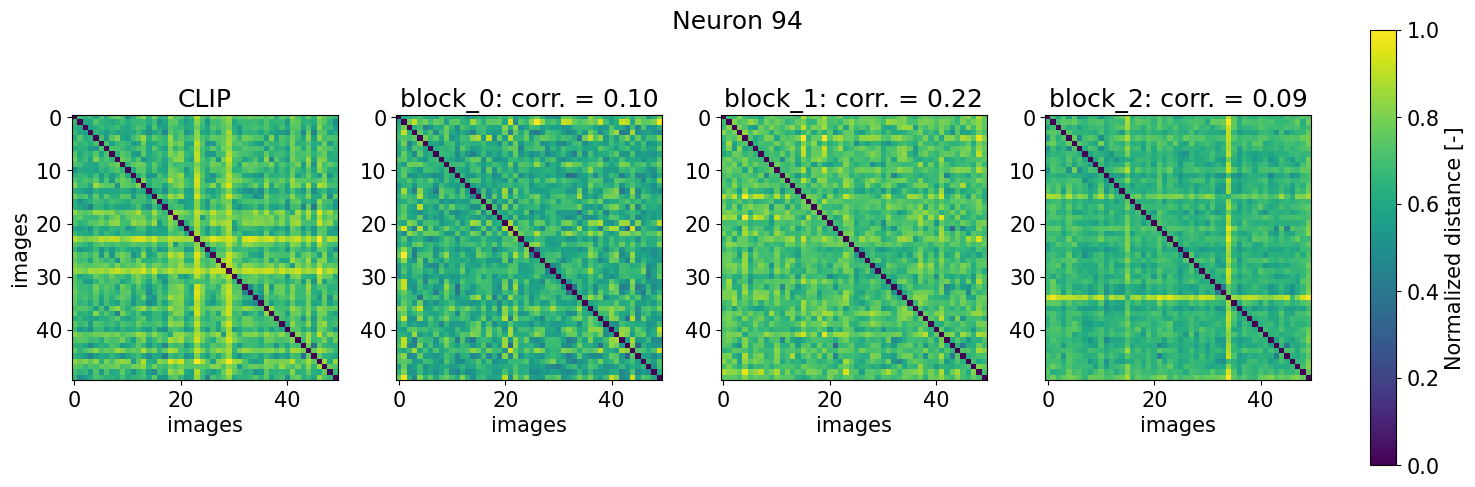

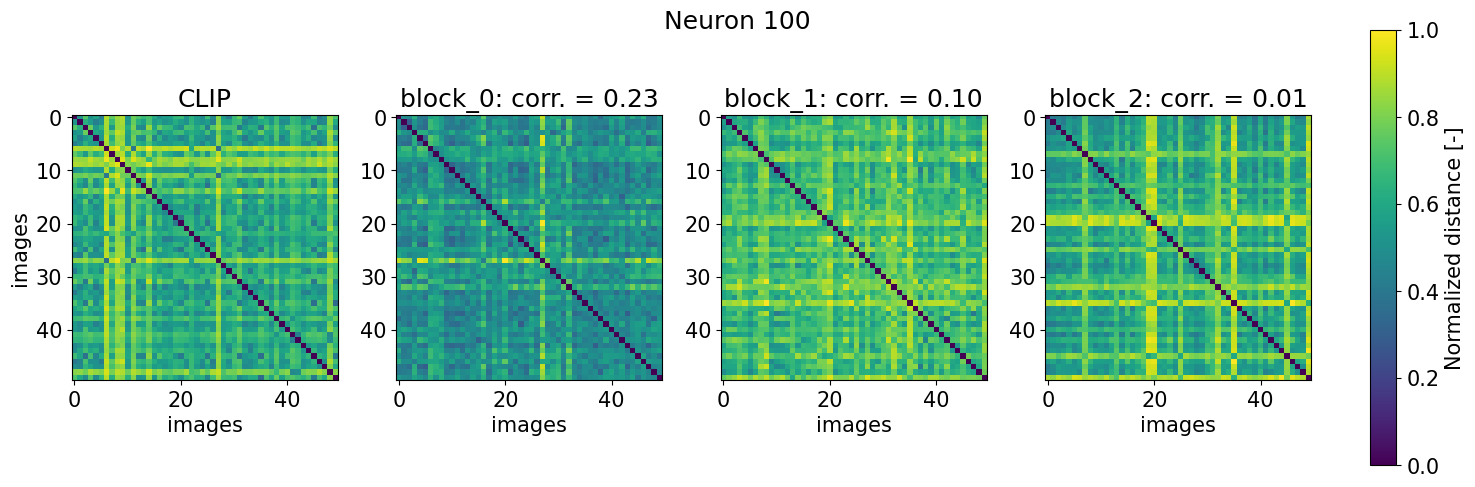

In [9]:
example_neurons_label_list = ["CLIP"] + layer_names[:-1]

num_subplots = 4

# Add an extra subplot for the colorbar
with_ratios = [1 for _ in range(num_subplots)]
with_ratios.append(0.1)

for i_neuron, neuron_id in enumerate(neurons_list):
    # Create a figure with GridSpec layout
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, num_subplots+1, width_ratios=with_ratios) 

    for i_subplot, label in enumerate(example_neurons_label_list):
        if label == "CLIP":
            clip_distance_this_neuron = clip_distance_all_neurons[neuron_id] # CLIP 
            distance_this_neuron = \
                clip_distance_all_neurons[neuron_id] / np.max(clip_distance_this_neuron)
        else: 
            other_distances_this_neuron = other_distances_all_neurons[neuron_id] # distances in other spaces.
            data_loc = label_list.index(label)
            distance_this_neuron = \
                other_distances_this_neuron[data_loc, :, :] / np.max(other_distances_this_neuron[data_loc, :, :])
            
        ax = plt.subplot(gs[i_subplot])
        im = ax.imshow(distance_this_neuron) # normalise the distance matrix 
        ax.set_xlabel("images")
        if label == "CLIP":
            ax.set_title("CLIP")
            ax.set_ylabel("images")
        else:
            ax.set_title(f'{label}: corr. = {corr_data[neuron_id, data_loc]:.2f}')
    
    # Add colorbar to the last subplot
    cbar = fig.colorbar(im, cax=plt.subplot(gs[i_subplot+1]))
    cbar.set_label('Normalized distance [-]')

    
    plt.tight_layout()
    plt.suptitle(f"Neuron {neuron_id}")
    plt.savefig(f"distance_matrix_{model_name}_{layer_name}_neuron{neuron_id}.svg", dpi=300)
    plt.show()


Embeddings/relevance vector in UMAP space

In [10]:
# n_clusters = 2

# fv_name = f"crp_files/{model_name}_{dataset_name}_{SPLIT}"
# batch_size = config["batch_size"]
# n_refimgs = 50
# mode = "activation"

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# dataset = get_dataset(dataset_name)(data_path=f"../../../{config['data_path']}", preprocessing=False, split=SPLIT)

# ckpt_path = config["ckpt_path"]

# model = get_fn_model_loader(model_name)(n_class=dataset.num_classes, ckpt_path=ckpt_path).to(device)
# model.eval()
# canonizers = get_canonizer(model_name)
# composite = EpsilonPlusFlat(canonizers)
# cc = ChannelConcept()

# layer_names = get_layer_names_model(model, model_name)
# layer_map = {layer: cc for layer in layer_names}

# attribution = CondAttribution(model)

# fv = FeatureVisualization(attribution, dataset, layer_map, preprocess_fn=dataset.preprocessing,
#                           path=fv_name, max_target="max", abs_norm=False)

# if not os.listdir(fv.RelMax.PATH):
#     fv.run(composite, 0, len(dataset), batch_size=batch_size)

# d_c_sorted, a, rf_c_sorted = load_maximization(fv.ActMax.PATH, layer_name)

# path = f"../../../results/global_features/{dataset_name}/{model_name}"

# for neuron_id in neurons_list:

#     fig, axs = plt.subplots(2 + n_clusters, len(example_neurons_label_list), dpi=300, figsize=(len(example_neurons_label_list) * 4/1.3, 6/1.4),
#                             gridspec_kw={'height_ratios': [len(example_neurons_label_list), 1, *np.ones(n_clusters).tolist()]},)
  
#     #for i, inds in enumerate(inds_):
#     for i_subplot, label in enumerate(example_neurons_label_list): # CLIP, block_0, ...

#         if i_subplot == 0: # CLIP
#             tensors = {}
#             with safe_open(f"{path}/latent_embeddings_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
#                 for key in f.keys():
#                     tensors[key] = f.get_tensor(key)
#             embeddings = tensors["CLIP"][:, :n_refimgs]

#         else: # pure 
#             tensors = {}
#             with safe_open( f"{path}/latent_features_{layer_name}_{SPLIT}_{label}.safetensors", framework="pt", device="cpu") as f:
#                 for key in f.keys():
#                     tensors[key] = f.get_tensor(key)
#             embeddings = tensors["cond_rel"][:, :n_refimgs]
            
#         ref_imgs = fv.get_max_reference([neuron_id], layer_name, mode, (0, n_refimgs),
#                                         composite=composite, rf=True, batch_size=n_refimgs,
#                                         plot_fn=vis_opaque_img_border)

#         embedding = umap.UMAP(n_neighbors=6, min_dist=0.3, spread=1.0)
#         X = embedding.fit_transform(embeddings[neuron_id])
#         x, y = X[:, 0], X[:, 1]
#         xmin = x.min() - 0.2 * (x.max() - x.min())
#         xmax = x.max() + 0.2 * (x.max() - x.min())
#         ymin = y.min() - 0.2 * (y.max() - y.min())
#         ymax = y.max() + 0.2 * (y.max() - y.min())
#         X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
#         positions = np.vstack([X.ravel(), Y.ravel()])
#         values = np.vstack([x, y])
#         kernel = stats.gaussian_kde(values, 0.5)
#         Z = np.reshape(kernel(positions).T, X.shape).T
#         axs[0][i_subplot].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
#         axs[0][i_subplot].scatter(x, y, alpha=0.7, c="black", s=10)

#         for j, img_ in enumerate(ref_imgs[neuron_id]):
#             imagebox = OffsetImage(img_.resize((100, 100)), zoom=0.15)
#             ab = AnnotationBbox(imagebox, (x[j], y[j]), frameon=True, pad=0)
#             axs[0][i_subplot].add_artist(ab)

#         axs[0][i_subplot].set_xticks([])
#         axs[0][i_subplot].set_yticks([])
#         axs[0][i_subplot].text(0.02, 0.98, f'#{neuron_id}', ha='left', va='top', transform=axs[0][i_subplot].transAxes)

#         resize = torchvision.transforms.Resize((150, 150))

#         NUM = 8
#         ref_imgs_ = ref_imgs[neuron_id]
#         grid = make_grid(
#             [resize(torch.from_numpy(np.asarray(k)).permute((2, 0, 1))) for k in ref_imgs_[:NUM]],
#             nrow=NUM,
#             padding=0)
#         grid = np.array(zimage.imgify(grid.detach().cpu()))
#         axs[1][i_subplot].imshow(grid)
#         axs[1][i_subplot].set_xticks([])
#         axs[1][i_subplot].set_yticks([])
#         axs[1][i_subplot].set_ylabel("all") if i_subplot == 0 else None


#         cluster = KMeans(n_clusters=n_clusters, n_init=20, random_state=123).fit(embeddings[neuron_id])
#         labels = np.array(cluster.labels_)

#         for lab in np.unique(labels):
#             ref_imgs_cluster = [r for k, r in enumerate(ref_imgs_) if labels[k] == lab]
#             grid = make_grid(
#                 [resize(torch.from_numpy(np.asarray(k)).permute((2, 0, 1))) for k in ref_imgs_cluster[:NUM]],
#                 nrow=NUM,
#                 padding=0)
#             grid = np.array(zimage.imgify(grid.detach().cpu()))
#             axs[2 + lab][i_subplot].imshow(grid)
#             axs[2 + lab][i_subplot].set_xticks([])
#             axs[2 + lab][i_subplot].set_yticks([])
#             axs[2 + lab][i_subplot].set_ylabel(f"{lab + 1}") if i_subplot == 0 else None
    
#         axs[0][i_subplot].set_title(label)
#     #
#     plt.tight_layout()
#     fig_path = f"../../../results/neuron_plots/{dataset_name}/{model_name}"
#     os.makedirs(fig_path, exist_ok=True)
#     figure_file_name = f"neurons_{neuron_id}_UMAP.svg"

#     plt.savefig(f"{fig_path}/{figure_file_name}", dpi=300)
#     plt.show()

### Summary (all neurons) 

#### bar plot

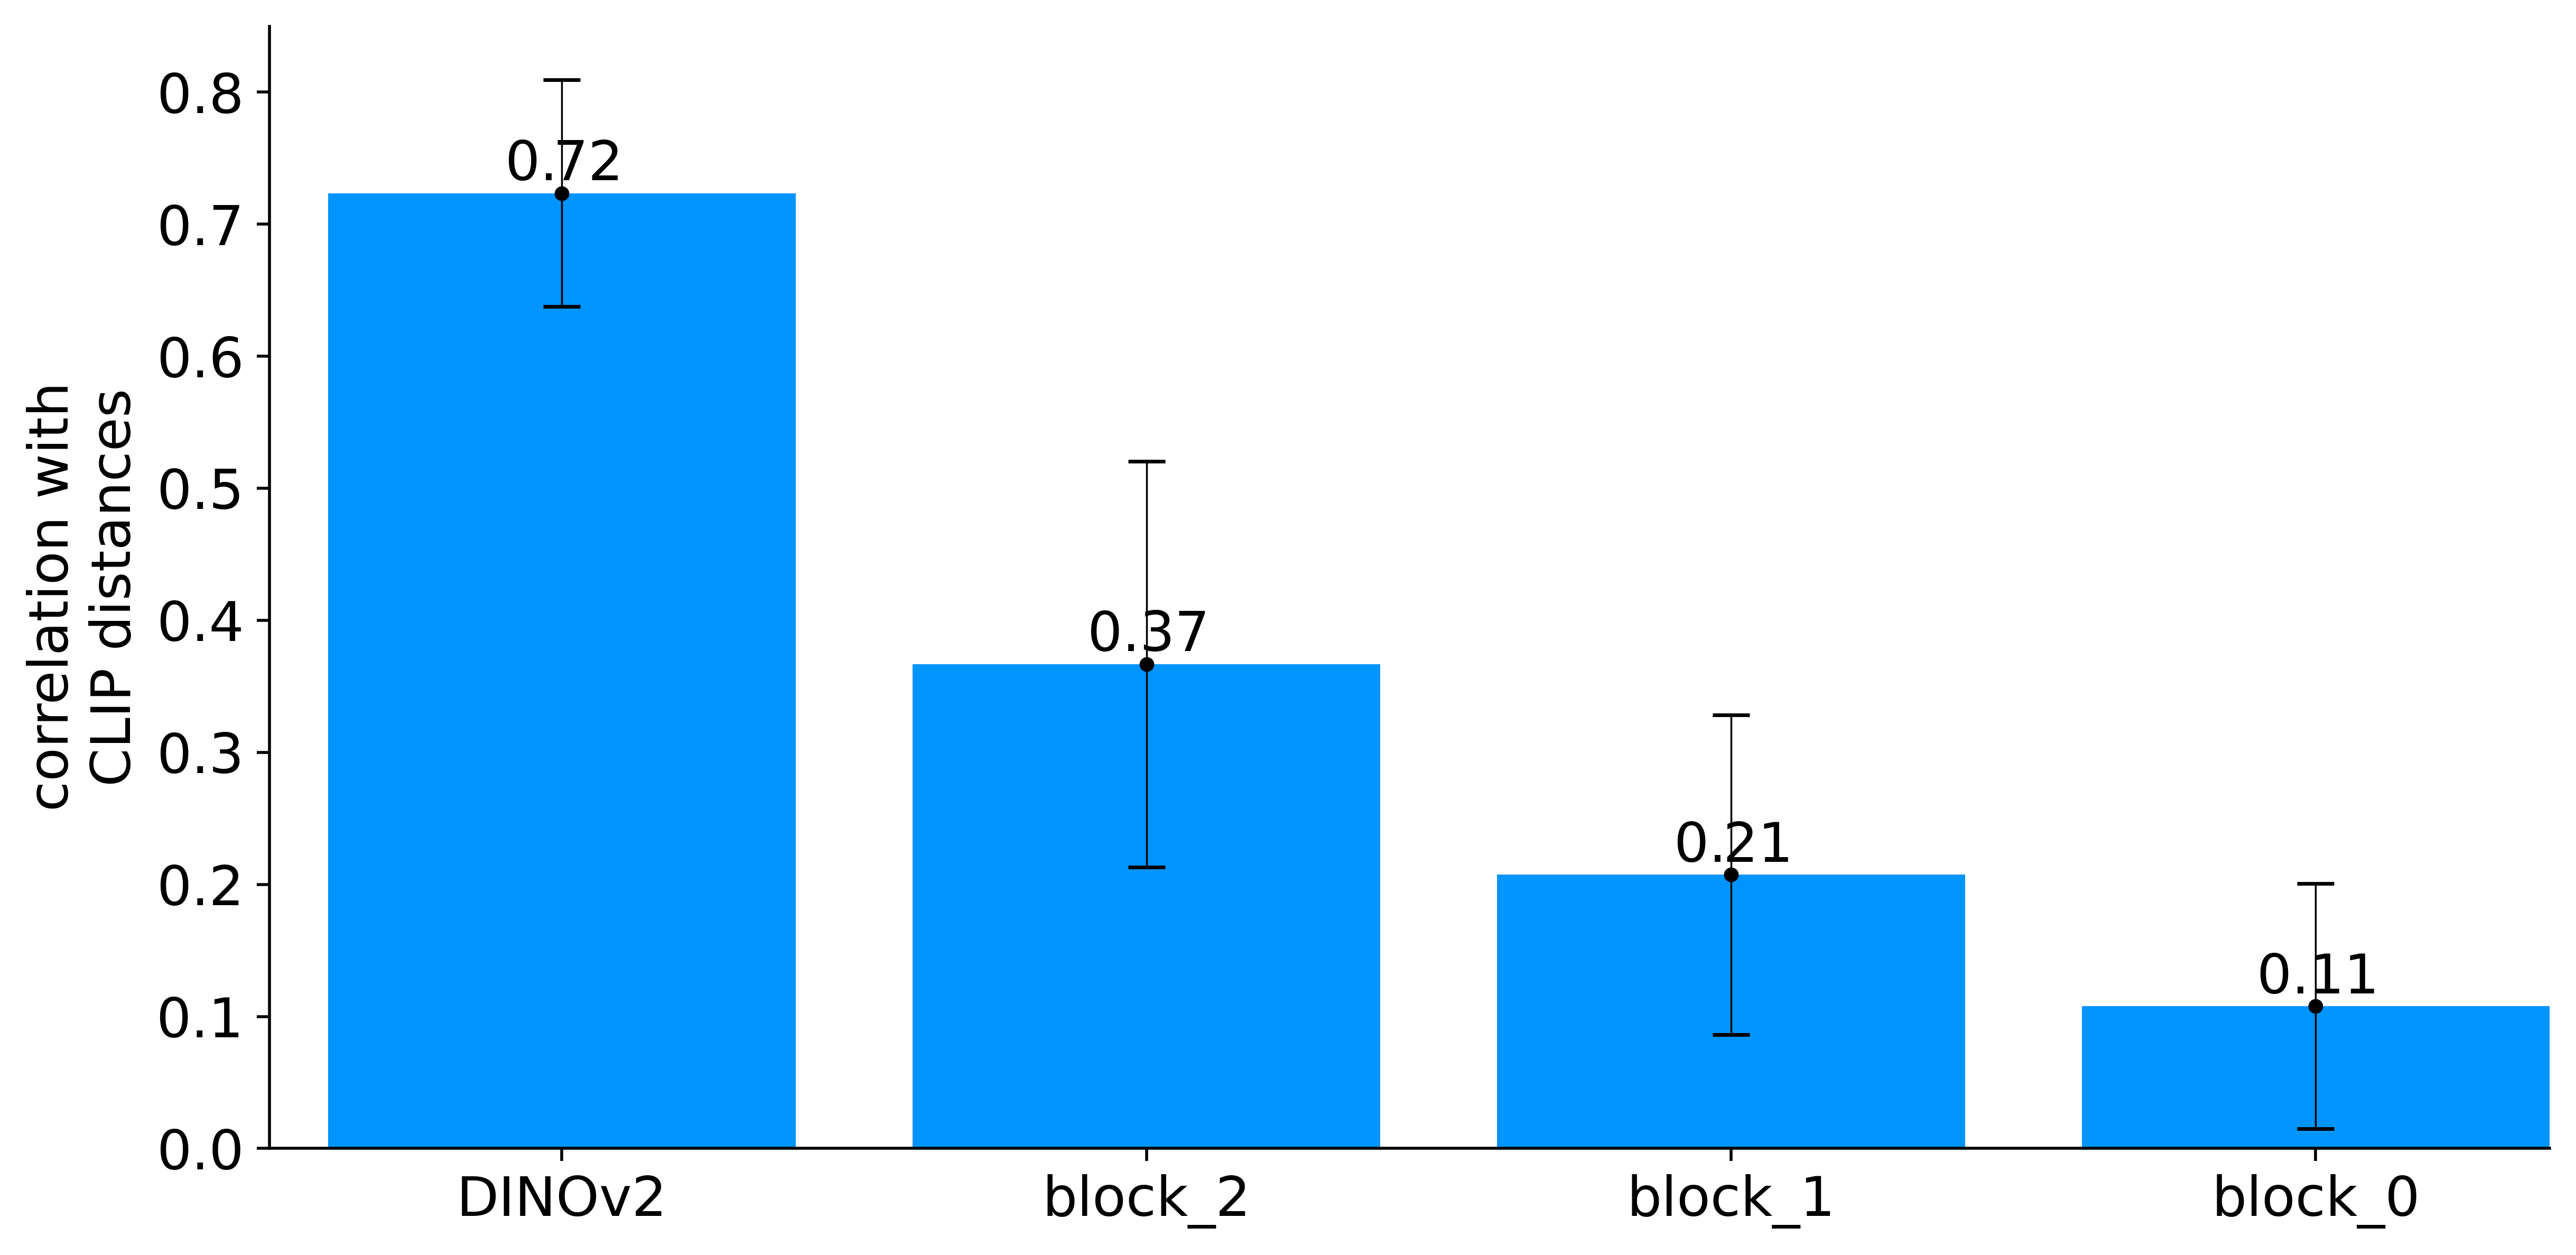

In [12]:
# plot the data 
def make_barplot(corr_data, label, model_name, layer_name):
    """
    Generates and displays a bar plot with error bars representing the correlation 
    between given data and CLIP distances. The plot is saved as an SVG file.

    Args:
        corr_data (numpy array): an array of correlation values. (neuons x spaces)
        label (list of str): A list of labels for the x-axis corresponding to each array in Y.
        model_name (str): The name of the model being analyzed.
        layer_name (str): The name of the layer whoses neurons you try to disentangle .S

    Returns:
        None

    Raises:
        ValueError: If the lengths of Y and label do not match.
    """
    
    #plt.rcParams['font.family'] = 'sans-serif'
    #plt.rcParams['font.sans-serif'] = 'Roboto'
    fig, ax = plt.subplots(1, 1, dpi=500, figsize=(10, 5)) 
    
    # compute mean across neuorns 
    mean_correlation = []
    std_correlation = []
    for i_space in range(corr_data.shape[1]):
        mean_correlation.append(np.mean(corr_data[:, i_space]))
        std_correlation.append(np.std(corr_data[:, i_space]))
    
    se_correlation = std_correlation / np.sqrt(corr_data.shape[0])

    plt.bar(label, mean_correlation, color="#0094FF")
    plt.errorbar(np.arange(len(label)),
                mean_correlation,
                yerr=std_correlation,
                color='k', fmt='.', elinewidth=0.5, capsize=5)  
    
    for i_space in range(corr_data.shape[1]):
        plt.text(i_space, mean_correlation[i_space] + 0.001, f"${mean_correlation[i_space]:.2f}$", ha="center", va="bottom")

    #plt.ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    plt.ylabel("correlation with \nCLIP distances")
    plt.xlim(-0.5, len(mean_correlation)-0.6)
    #plt.title(f'Disentangling neurons in {layer_name}')
    plt.tight_layout()
    plt.savefig(f"correlation_CLIP_{model_name}_{layer_name}.svg", dpi=300)
    plt.show()

make_barplot(corr_data, label_list, model_name, layer_name)

 #### scatter plot

[4, 94, 100]


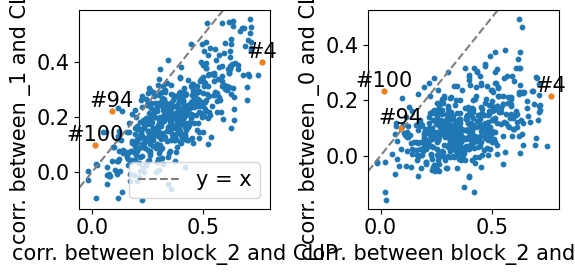

In [ ]:
# block_1_improved_neurons_sample_list = \
#     list(np.where(np.logical_and(corr_data[:, block_1_loc] > 0.4, corr_data[:, block_2_loc] < 0.4))[0])
# print(block_1_improved_neurons_sample_list)
# block_1_improved_neurons_sample_list.append(4)
# neurons_list = block_1_improved_neurons_sample_list
#neurons_list = []
print(neurons_list)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
i_subplot = 0
for i_space, label in enumerate(label_list):
    
    # skip non-PURE spaces and the original PURE (use this data for x-axis)
    if label == "DINOv2" or label == "activations" or label == "block_2":
        continue
    
    original_pure_data_loc = label_list.index("block_2")
    data_loc = label_list.index(label)

    default_marker_size = plt.rcParams['lines.markersize']
    axes[i_subplot].scatter(corr_data[:, original_pure_data_loc], corr_data[:, data_loc], s=10)
    axes[i_subplot].scatter(corr_data[neurons_list, original_pure_data_loc], corr_data[neurons_list, data_loc], s=10)
    
    for neuron_id in neurons_list:
        axes[i_subplot].text(corr_data[neuron_id, original_pure_data_loc], corr_data[neuron_id, data_loc], f"#{neuron_id}", ha="center", va="bottom")
    
    axes[i_subplot].set_xlabel(f"corr. between block_2 and CLIP")
    axes[i_subplot].set_ylabel(f"corr. between {label[5:]} and CLIP")
    
    xlim = axes[i_subplot].get_xlim()
    ylim = axes[i_subplot].get_ylim()
    axes[i_subplot].set_xlim(xlim[0], xlim[1])
    axes[i_subplot].set_ylim(ylim[0], ylim[1])
    # Add y = x line
    x_vals = np.linspace(xlim[0], xlim[1], 100)
    y_vals = x_vals
    axes[i_subplot].plot(x_vals, y_vals, linestyle='--', color='gray', label='y = x')
    if i_subplot == 0:
        axes[i_subplot].legend()
    i_subplot += 1

plt.tight_layout()
plt.savefig(f"correlation_scatter_{model_name}_{layer_name}.svg", dpi=300)
plt.show()

Distance (optional) 

In [14]:
#copied from eval_CLIP_alighnment
if skip_distance_evaluation == False:
    n_clusters = 2

    path = f"../../../results/interpretability/{dataset_name}/{model_name}"
    vals_full = torch.load(f"{path}/interpretability_{n_clusters}clusters_{layer_name}_{SPLIT}_{attribution_layer_name}.pt")

    inner_CLIP = vals_full["CLIP"][0]
    inter_CLIP = vals_full["CLIP"][1]
    inner_rel = vals_full["PURE"][0]
    inter_rel = vals_full["PURE"][1]
    inner_act = vals_full["Activation"][0]
    inter_act = vals_full["Activation"][1]
    inner_dino = vals_full["DINO"][0]
    inter_dino = vals_full["DINO"][1]
    overall_ = vals_full["overall"]
    neuron_indices = vals_full["neuron_indices"]

    # vals_full = {
    #     "CLIP": [inner_CLIP, inter_CLIP],
    #     "PURE": [inner_rel, inter_rel],
    #     "Activation": [inner_act, inter_act],
    #     "DINO": [inner_dino, inter_dino],
    #     "overall": overall_,
    #     "neuron_indices": neuron_indices,
    # }

    vals = {
        "CLIP": [np.mean(inner_CLIP), np.mean(inter_CLIP), np.std(inner_CLIP) / len(inner_CLIP),
                np.std(inter_CLIP) / len(inter_CLIP)],
        "PURE": [np.mean(inner_rel), np.mean(inter_rel), np.std(inner_rel) / len(inner_rel),
                np.std(inter_rel) / len(inter_rel)],
        "Activation": [np.mean(inner_act), np.mean(inter_act), np.std(inner_act) / len(inner_act),
                    np.std(inter_act) / len(inter_act)],
        "DINO": [np.mean(inner_dino), np.mean(inter_dino), np.std(inner_dino) / len(inner_dino),
                    np.std(inter_dino) / len(inter_dino)],
    }

    plt.rcParams['text.usetex'] = False
    plt.figure(dpi=300)

    x = ["CLIP", "DINO", "PURE", "Activation"]

    overall = np.mean(overall_)

    plt.bar(x, height=[vals[m][1] for m in x], label="inter", color="#E33FDD")
    plt.bar(x, height=[vals[m][0] for m in x], label="inner", color="#0094FF")
    for i, m in enumerate(x):
        plt.text(i, vals[m][0], f"${vals[m][0]:.2f}\pm{vals[m][2]:.2f}$", ha="center", va="bottom")
        plt.text(i, vals[m][1], f"${vals[m][1]:.2f}\pm{vals[m][3]:.2f}$", ha="center", va="bottom")
        # plt.text(i, vals[m][0], f"{vals[m][0]:.2f}", ha="center", va="bottom")

    plt.legend(loc="lower right")
    plt.ylabel("distance of CLIP embeddings")
    plt.show()